# This is an example of absolute shear-wave velocities conversion to temperature using different methods 

## Introduction
### NEED TO WRITE: motivation and expectations

# Importing requirements

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy import interpolate
import math

## Velocity conversions CS
from VelocityConversion import MantleConversion
np.set_printoptions(precision=2, suppress=True)

In [2]:
# These are just cosmetics
plt.style.use('seaborn-white')
#plt.style.use('ggplot')
plt.rc('font', size=16) #controls default text size
plt.rc('axes', titlesize=16) #fontsize of the title
plt.rc('axes', labelsize=16) #fontsize of the x and y labels
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend

## Data

In order to have a fixed data (i.e. tomography model), we take CSEM North Antlantic model (https://cos.ethz.ch/research/CSEM.html). We stack the velocities as a function of ocean-floor age. The advantage of doing this is that we can analystical calculate thermal structure of the oceanic lithosphere based on plate or half-space cooling model and compare the converted temperatures direcly. This also allows us to, in future, extract additional datasets (e.g., gravity, heat-flow etc) to further constrain and test the conversion methods.

In [3]:
###############
# data format
# age(Ma) depth(km) Vs(km/s)
# 
tomo_NA_stack = np.loadtxt('./data_tomo/NA_age_vel_stack.dat',comments='#')

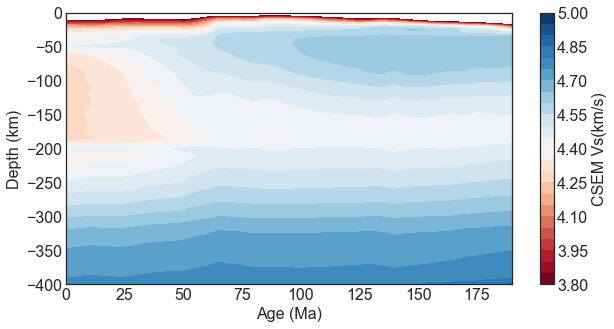

In [4]:
tri = Triangulation(tomo_NA_stack[:,0],-tomo_NA_stack[:, 1])
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
m_v_in = ax.tricontourf(tri, tomo_NA_stack[:, 2],cmap='RdBu',levels=np.arange(3.8,5,0.05))
ax.set_ylim([-400,0])
ax.set_xlabel('Age (Ma)')
ax.set_ylabel('Depth (km)')
fig.colorbar(m_v_in, ax=ax, label='CSEM Vs(km/s)', orientation='vertical')

First, we will do the conversion using Gibbs-free energy minimization.

# Loading the library containing functions to do the conversions

Briefly write about the method

In [5]:
import V2RhoT_gibbs_lib as lib

# Loading velcoity and density table from the Gibbs-free energy minimization
First, we will load the pre-computed anharmonic seismic velocties using the Generator subprogram of LitMod2D_2.0 which used Perple_X to do the Gibbs-free-energy minimization. Tables are generated for a give bulk-rock composition in terms of 5 major oxides (NCFMAS system) that account for ~99% composition of the mantle. The precomputed "look-up tables" are generated using the augmented‐modified version of Holland and Powell (1998) thermodynamic database (Afonso & Zlotnik, 2011). The choice of this thermodynamic is based on Kumar et al., 2020. 

Available pre-computed tables in the databases_gibbs where first name indicates composition (see table composition) and second indicates thermodynamic database used (see table Thermodynamic database key).

### Compositions
| Composition |                                   SiO2   | Al2O3   | Feo   | MgO   | CaO   | Na2O   | Mg#   |
|-------------|                                   --------|---------|-------|-------|-------|-------|-------|
|   Primitive Upper mantle (PUM)                  | 45.0   |4.5      |8.1    |37.8   |3.6    |0.36   |89.3|
|   Depleted Mid-oceanic-ridge-basalt (DMM)       | 44.7   |3.98     |8.18    |38.73   |3.17    |0.13   |89.4|
|   Pyrolite                                      | 45.1   |4.6      |7.6    |38.1   |3.1    |0.4   |89.9|
|   Average Garnet Tecton (Tc_1)                  | 44.5   |3.5      |8.0    |39.8   |3.1    |0.24   |89.8|


### Thermodynamic database key:

| Table name    | Description |
|---------------|-------------|
|   _HP      |Augmented‐modified version of Holland & Powell (1998) thermodynamic database (Afonso & Zlotnik, 2011)      |
|   _3       |Stixrude 2008 (EPSL)| 
|            |             |
|            |             |

@ajay6763: Add more pre-computed tables

In [6]:
DMM_no_atten = np.loadtxt('./databases/DMM_HP',comments='#')

# Correction for anelasticity and melts
Velocities computed from Perple_X are anharmonic and in order compare them with the velocities modelled in tomography we need to correct for anelasticity and melts and both of these decreases the seimic velocity.

In [7]:

# correction using grain size = 10 mm and oscillatio period of 75 seconds.
# Attenuation model of Jackson and Faul 2010
# Function: lib.atten_correction (T (oC),P (Pascal),VP (km/s),Vs (km/s),oscilation period (s), grain size (mm))
DMM_atten_corrected = np.copy(DMM_no_atten)
for i in range(len(DMM_atten_corrected)):
    DMM_atten_corrected[i,3],DMM_atten_corrected[i,4] = lib.atten_correction(DMM_atten_corrected[i,0],DMM_atten_corrected[i,1]*100000,
                                                         DMM_atten_corrected[i,3],DMM_atten_corrected[i,4],75,10)

# correction for melts
# These are relations from lab experiments. More details in Afonso et al., 2016 III
# Function: lib.velocity_melt_correction_mantle (T (oC),P (GPa),VP (km/s),Vs (km/s),oscilation period (s), grain size (mm))
DMM_atten_melt_corrected = np.copy(DMM_atten_corrected)
melt = np.zeros_like(DMM_atten_melt_corrected[:,0])
for i in range(len(DMM_atten_melt_corrected)):
    DMM_atten_melt_corrected[i,3],DMM_atten_melt_corrected[i,4],melt[i] = lib.velocity_melt_correction_mantle(DMM_atten_melt_corrected[i,0]-273.15,
                                                                                             DMM_atten_melt_corrected[i,1]/10000,
                                                             DMM_atten_melt_corrected[i,3],DMM_atten_melt_corrected[i,4])

# Now doing the conversion

In [8]:
# vel_to_temp function takes 3 arguments which in sequence are depth(km), Vs(km), and the Table which we corrected for anelasticity and metls above
# The out in sequence is -depth(km), Temperature(oC), Density(kg/m3), V_obs-V_model
out_gibbs=lib.vel_to_temp(tomo_NA_stack[:,1],tomo_NA_stack[:,2],DMM_atten_melt_corrected)


# The out in sequence is -depth(km), Pressure (bar), Temperature(oC), Density(kg/m3), V_obs-V_model
#out_gibbs=lib.vel_to_temp_P_in(tomo_NA_stack[:,1],tomo_NA_stack[:,2],DMM_atten_melt_corrected)

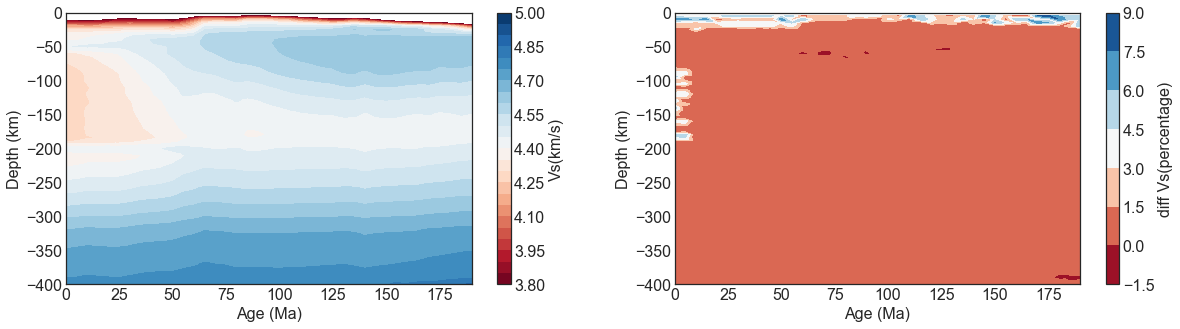

In [9]:
tri = Triangulation(tomo_NA_stack[:,0],-tomo_NA_stack[:, 1])
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False,figsize=(20,5))
m_v_in = ax[0].tricontourf(tri, tomo_NA_stack[:, 2],cmap='RdBu',levels=np.arange(3.8,5,0.05))
m_v_diff = ax[1].tricontourf(tri, (out_gibbs[:,4]/tomo_NA_stack[:, 2])*100,cmap='RdBu')

ax[0].set_ylim([-400,0])
ax[0].set_xlabel('Age (Ma)')
ax[0].set_ylabel('Depth (km)')
fig.colorbar(m_v_in, ax=ax[0], label='Vs(km/s)', orientation='vertical')

ax[1].set_ylim([-400,0])
ax[1].set_xlabel('Age (Ma)')
ax[1].set_ylabel('Depth (km)')
fig.colorbar(m_v_diff, ax=ax[1], label='diff Vs(percentage)', orientation='vertical')

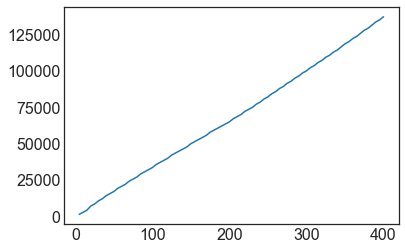

In [10]:
plt.plot(out_gibbs[:,0],out_gibbs[:,1])

# Now we will convert the same data with python implementation of Goes method in python by CM
We already loaded this above

In [11]:
# Just formating the data required
data=tomo_NA_stack[:,0];
data=np.column_stack((data,tomo_NA_stack[:,0]))
data=np.column_stack((data,tomo_NA_stack[:,1]))
data=np.column_stack((data,tomo_NA_stack[:,2]*1000))


In [12]:
# Now doing the conversion

In [13]:
MC = MantleConversion()
MC.LoadArray(data)
MC.SetVelType('S')
MC.SetAlpha('T')
## DMM Workman & Hatz
#assemblage = {"ol": 0.57,"cpx": 0.13,"opx": 0.20,"gnt": 0.1,"XFe": 0.88}
assemblage = {"ol": 0.57,"cpx": 0.13,"opx": 0.20,"gnt": 0.1}
## Constanza
#UM
assemblage = {"ol": 0.60,"cpx": 0.19,"opx": 0.17,"gnt": 0.04,"XFe": 0.10}
#LM
assemblage = {"ol": 0.63,"cpx": 0.02,"opx": 0.30,"gnt": 0.05,"XFe": 0.08}
#assemblage = {"ol": 0.60,"cpx": 0.19,"opx": 0.17,"gnt": 0.04}
#assemblage = {"ol": 1.0,"cpx": 0,"opx": 0,"gnt": 0}
MC.SetMineralogy(assemblage)
MC.Convert()
#MC.CalcPT()

> XFe assigned to 0.08
> All mineral phases are known
> Sum of mineral phases equals 1.0
Filling tables
> Number of depth values: 80
> Number of temperatures: 2701
> Pressure calculation  : AK135
> T range: 300.0 to 3000.0 steps 1.0
Starting temperature estimation
> Progress: 100%
> Done!


# Half-space cooling model

In [14]:
def half_space_ocean(depth,Age,T_mantle,T_surface):
    '''
    depth: in km
    Age: in Ma
    T_mantle: potential temeprature of the mantle (oC)
    T_surf: surface temperatue (oC)
    diffusivity is hard set as kappa
    '''
    kappa = 1e-6;
    SecYear = 3600*24*365.25
    T = T_surface + (T_mantle-T_surface)*(math.erf(depth/(2*math.sqrt(kappa*Age*SecYear*1.0e6))))
    return T


In [15]:

T_half_space = np.zeros_like(tomo_NA_stack[:,0])
for i in range(len(tomo_NA_stack)):
    depth = tomo_NA_stack[i,1]*1000.0
    Age   = tomo_NA_stack[i,0]
    T=half_space_ocean(depth,Age,1300,0)
    T_half_space[i]=T #half_space_ocean(tomo_in[index[i],1]*1000.0,tomo_in[index[i,0]],1300,15)
T_half_space=np.nan_to_num(T_half_space, nan=0, posinf=0)

c:\users\kumar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


# Now we compare the converted temperatures

Text(0.5, 1.0, 'HSC Tm=1300')

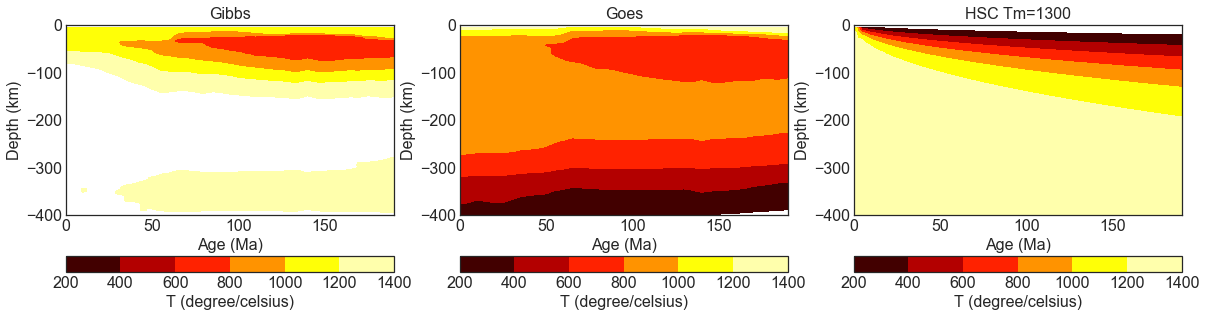

In [19]:
tri = Triangulation(tomo_NA_stack[:,0],-tomo_NA_stack[:, 1])
fig, ax = plt.subplots(1, 3,sharex=False, sharey=False,figsize=(20,5))
m_v_in_gibbs = ax[0].tricontourf(tri, out_gibbs[:,2],cmap='hot',levels=np.arange(200,1500,200))
#m_v_in_gibbs = ax[0].tricontour(tri, out_gibbs[:,1],cmap='hot',levels=np.arange(0,1400,100))
m_v_in_goes = ax[1].tricontourf(tri, MC.Result_T-273,cmap='hot',levels=np.arange(200,1500,200))
#m_v_in_goes = ax[1].tricontour(tri, MC.Result_T-273,cmap='hot',levels=np.arange(0,1400,100))
m_v_in_HS = ax[2].tricontourf(tri, T_half_space,cmap='hot',levels=np.arange(200,1500,200))
#m_v_in_HS = ax[2].tricontour(tri, T_half_space,cmap='hot',levels=np.arange(0,1400,100))


for a in ax:
        #a.set_aspect('equal')
        a.set_ylim([-400,0])
        a.set_xlabel('Age (Ma)')
        a.set_ylabel('Depth (km)')
        a.set_title('')
fig.colorbar(m_v_in_gibbs, ax=ax[0], label='T (degree/celsius)', orientation='horizontal')
fig.colorbar(m_v_in_goes, ax=ax[1], label='T (degree/celsius)', orientation='horizontal')
fig.colorbar(m_v_in_HS, ax=ax[2], label='T (degree/celsius)', orientation='horizontal')
ax[0].set_title('Gibbs')
ax[1].set_title('Goes')
ax[2].set_title('HSC Tm=1300')

#fig.colorbar(m_t_out, ax=ax[2], label='Temperature (Celcius)', orientation='horizontal')
#fig.colorbar(m_dens_out, ax=ax[3], label='Density (g/cm3)', orientation='horizontal')
#fig.suptitle(title, fontsize=16)
#ax.set_ylim([-400,0])
#ax.set_xlabel('Distance (km)')
#ax.set_ylabel('Depth (km)')
#fig.colorbar(m_v_in_gibbs, ax=ax[0], label='Temperature (degree/celcius)', orientation='vertical')

Text(0.5, 1.0, 'keith')

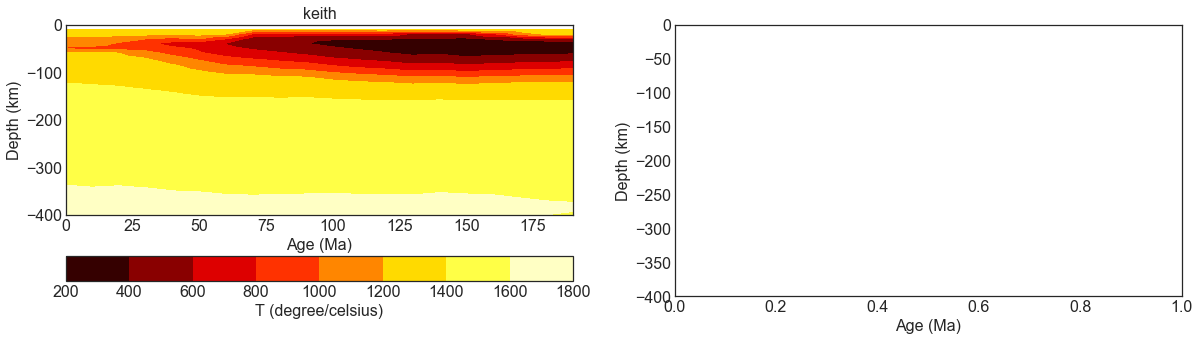

In [16]:
# Here I am loading conversions using Keith method
T_V2T=np.loadtxt('./data/V2T.out',comments="#")
tri = Triangulation(T_V2T[:,0],-T_V2T[:, 2]/1000)
fig, ax = plt.subplots(1, 2,sharex=False, sharey=False,figsize=(20,5))
m_v_in_keith = ax[0].tricontourf(tri, T_V2T[:, 3],cmap='hot')#,levels=np.arange(200,1500,200))
for a in ax:
        #a.set_aspect('equal')
        a.set_ylim([-400,0])
        a.set_xlabel('Age (Ma)')
        a.set_ylabel('Depth (km)')
        a.set_title('')
fig.colorbar(m_v_in_keith, ax=ax[0], label='T (degree/celsius)', orientation='horizontal')
ax[0].set_title('keith')


## Some stats 
 WRITE ABOUT WHAT EXACTLY IS DONE HERE

In [17]:
def stats(T_model,T_HSM,tomo,model):
    '''
    Calculates difference w.r.t to Half space cooling model.
     Subplot 1: Histogram of the difference
     Subplot 2: Frequency distribution (balck higher; grey lower) of the difference as a function of depth
     Subplot 3: Frequency distribution (balck higher; grey lower) of the difference as a function of Age
   These plots are generated to understand where exactly does the model differs from that of Half Space cooling model\
   Will need to think and discuss how else or better we can visualise the differences->> @ajay6763  
    Arguments info:
    T_mode: converted temperature
    T_HSM : half space cooling temperature
    tomo  : input tomography 
    model : title of the model
    '''
    fig  = plt.figure(figsize=(20,4))
    ax1 = plt.subplot(131)
    bins=20
    sigma = np.std(T_model-T_HSM)
    mu    = np.mean(T_model-T_HSM)
    n, bins, patches = plt.hist(T_model-T_HSM, bins,density=False)
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    #ax1.plot(bins, y, '--')
    ax1.set_xlabel('Temperature (Celcius)')
    ax1.set_ylabel('Count')
    ax1.set_title(str(model)+'-HSC Histogram')
    
    ax2 = plt.subplot(132)
    ax2.hist2d(T_model-T_HSM,-tomo[:,1] ,bins=10,cmap=plt.cm.binary)
    #plt.colorbar(ax2,label='Count', orientation='vertical')
    ax2.axvline(x=np.mean(T_model-T_HSM),color='blue', linestyle='--')
    ax2.axvline(x=np.median(T_model-T_HSM),color='red', linestyle='--')
    ax2.set_xlabel('T diff (Celcius)')
    ax2.set_ylabel('Depth (km)')
    ax2.set_title("Mean dT  ="+ str(np.mean(T_model-T_HSM))+
          "\n std   ="+ str(np.std(T_model-T_HSM)))
    
    ax3 = plt.subplot(133)
    ax3.hist2d(T_model-T_HSM, tomo[:,0],bins=25,cmap=plt.cm.binary)
    #ax3.colorbar(label='Count', orientation='vertical')
    ax3.axvline(x=np.mean(T_model-T_HSM),color='blue', linestyle='--')
    ax3.axvline(x=np.median(T_model-T_HSM),color='red', linestyle='--')
    ax3.set_xlabel('T diff (Celcius)')
    ax3.set_ylabel('Age (Ma)')
    ax3.set_title("Mean dT  ="+ str(np.mean(T_model-T_HSM))+
          "\n std   ="+ str(np.std(T_model-T_HSM)))
    plt.savefig(str(model)+"stats.png", dpi=500)

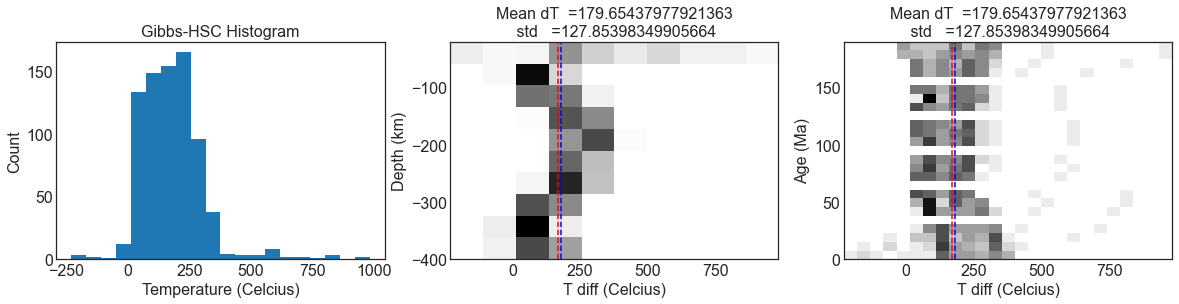

In [18]:
stats(out_gibbs[:,1],T_half_space,tomo_NA_stack,'Gibbs')

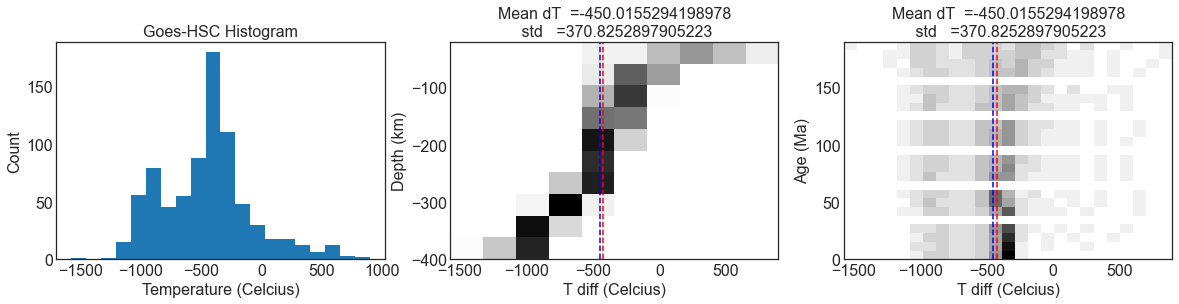

In [19]:
stats(MC.Result_T-273,T_half_space,tomo_NA_stack,'Goes')